In [31]:
!pip install praw nltk matplotlib seaborn scikit-learn statsmodels textstat
import praw
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import textstat


In [32]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [33]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [34]:
# Reddit API authentication
reddit = praw.Reddit(
    client_id='yUSNFU5VIf23DSXeZk3HFg',
    client_secret='Jh0VV0jol0PrH3uBeTM4K2CUq4oXdA',
    user_agent='praw:DataMiningFinalProject:u/USFDataMiningProject'
)

In [35]:
# Subreddits to analyze
subreddits = ['teenagers', 'finance', 'AskAcademia', 'science', 'books', 'dankmemes', 'conservative', 'liberal', 'gaming', 'sports']

In [36]:
# Spam filtering
def is_spam(comment):
    #if len(comment) < 20:  # Too short
        #return True
    #if comment.count('http') > 2:  # Too many links
       # return True
    return False

In [37]:
# Fetching comments + number of replies
def fetch_comments(subreddit_name, num_comments=5000):
    subreddit = reddit.subreddit(subreddit_name)
    comments = []
    for comment in subreddit.comments(limit=5000):
        if not is_spam(comment.body):
            comments.append(comment.body)
            if len(comments) >= num_comments:
                return comments
    return comments

In [38]:
# Preprocessing text
def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

In [39]:
def predict_reading_category(text):
    grade_level = textstat.flesch_kincaid_grade(text)

    if grade_level < 6:
        return 'Elementary'
    elif 6 <= grade_level <= 8:
        return 'Middle School'
    elif 9 <= grade_level <= 12:
        return 'High School'
    else:
        return 'College and Above'


In [40]:
# Calculate literacy features
def calculate_features(comments_with_replies):
    features = []
    for comment in comments:
        tokens = preprocess_text(comment)
        num_words = len(tokens)
        avg_word_length = np.mean([len(word) for word in tokens]) if tokens else 0
        comment_length = len(comment)
        grade_level = textstat.flesch_kincaid_grade(comment)
        reading_category = predict_reading_category(comment)
        features.append((num_words, avg_word_length, comment_length, grade_level, reading_category))
    return features


In [41]:
data = []

for subreddit in subreddits:
    comments = fetch_comments(subreddit)
    features = calculate_features(comments)
    for feature in features:
        data.append({
            'subreddit': subreddit,
            'word_count': feature[0],
            'avg_word_length': feature[1],
            'comment_length': feature[2],
            'reading_grade_level': feature[3],
            'reading_category': feature[4]
        })


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [42]:
# Creating DataFrame
df = pd.DataFrame(data)
print(df.head())

   subreddit  word_count  avg_word_length  comment_length  \
0  teenagers           1              8.0               8   
1  teenagers           1              8.0               8   
2  teenagers           5              4.4              52   
3  teenagers           2              8.0              17   
4  teenagers           1              8.0               8   

   reading_grade_level   reading_category  
0                  8.4  College and Above  
1                  8.4  College and Above  
2                  2.9         Elementary  
3                  8.8  College and Above  
4                  8.4  College and Above  


In [43]:
# Exploratory Data Analysis

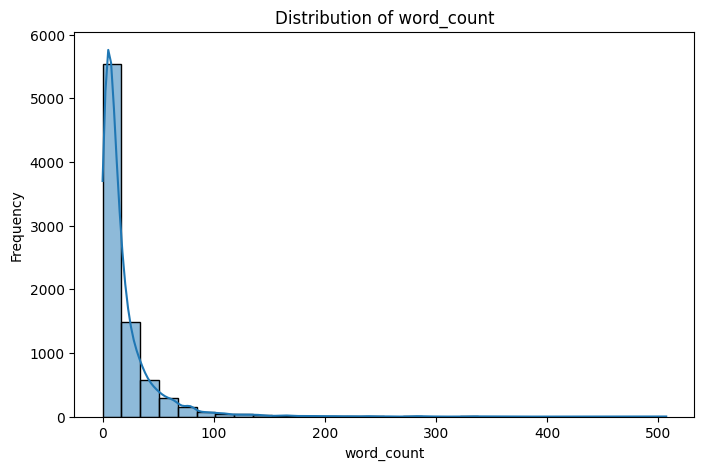

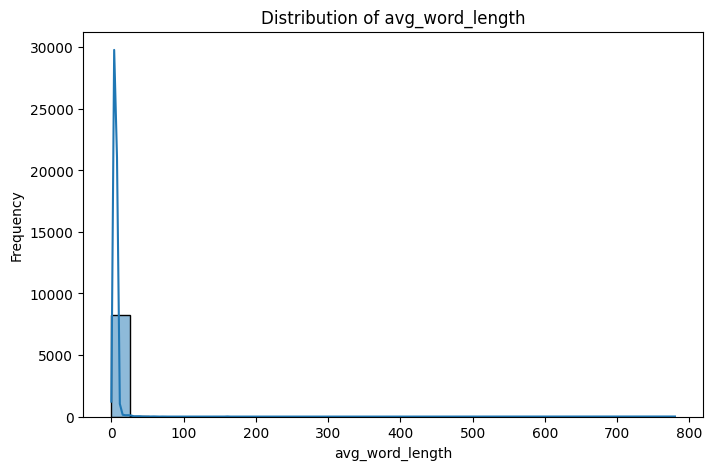

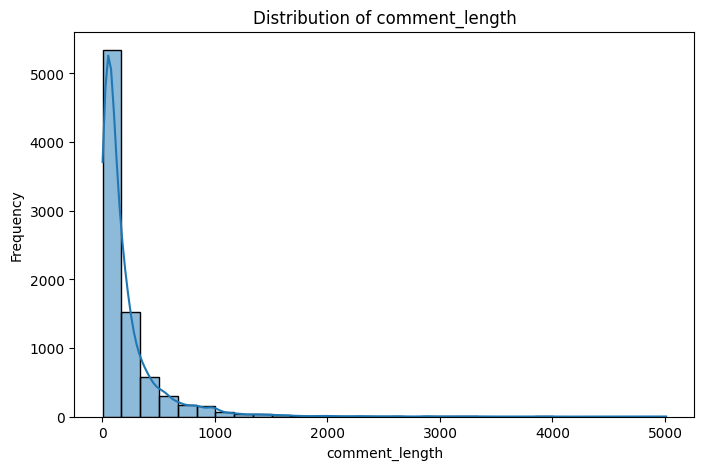

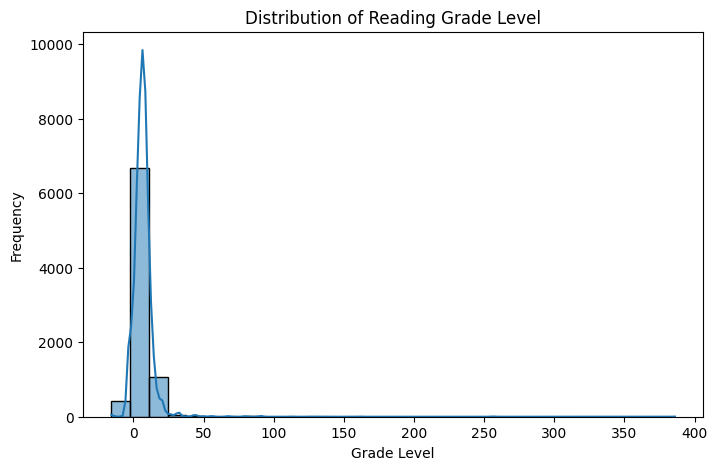

In [44]:
# Histograms for each feature
for col in ['word_count', 'avg_word_length', 'comment_length']:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['reading_grade_level'], kde=True, bins=30)
plt.title('Distribution of Reading Grade Level')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.show()


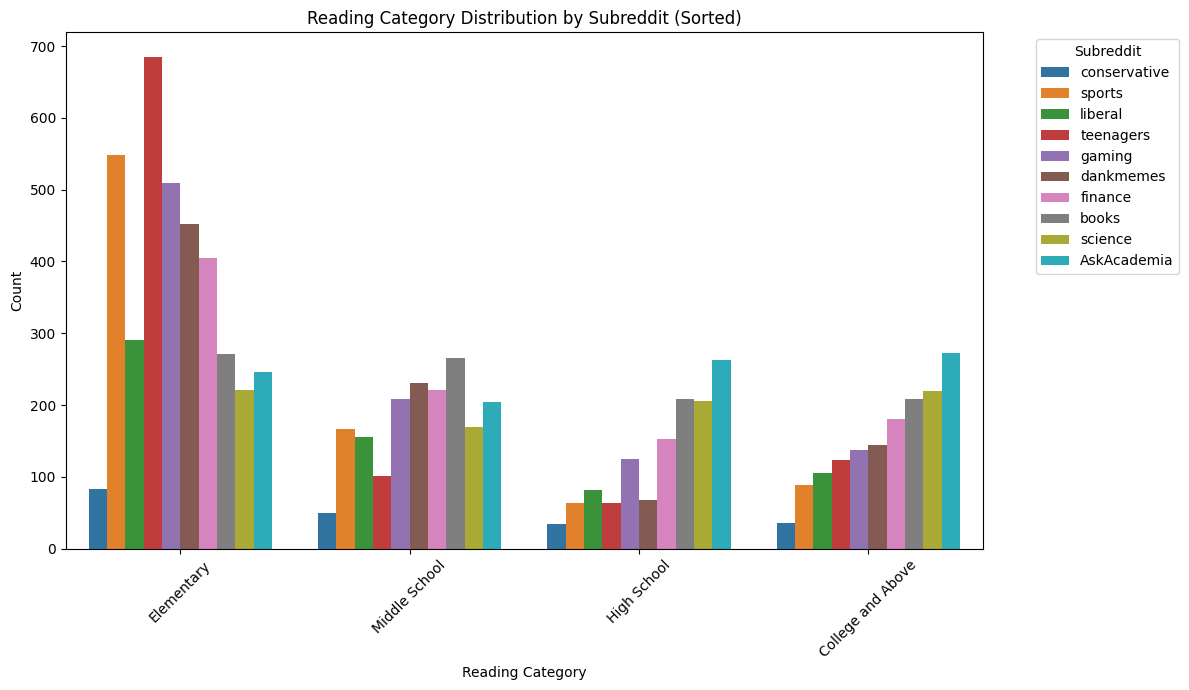

In [45]:
reading_order = ['Elementary', 'Middle School', 'High School', 'College and Above']
counts = df.groupby(['reading_category', 'subreddit']).size().reset_index(name='count')
counts = counts.sort_values(by=['reading_category', 'count'], ascending=[True, True])
counts['reading_category'] = pd.Categorical(counts['reading_category'], categories=reading_order, ordered=True)

plt.figure(figsize=(12,7))
sns.barplot(
    data=counts,
    x='reading_category',
    y='count',
    hue='subreddit',
    hue_order=counts['subreddit'].unique(),
    dodge=True
)
plt.title('Reading Category Distribution by Subreddit (Sorted)')
plt.xlabel('Reading Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Subreddit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


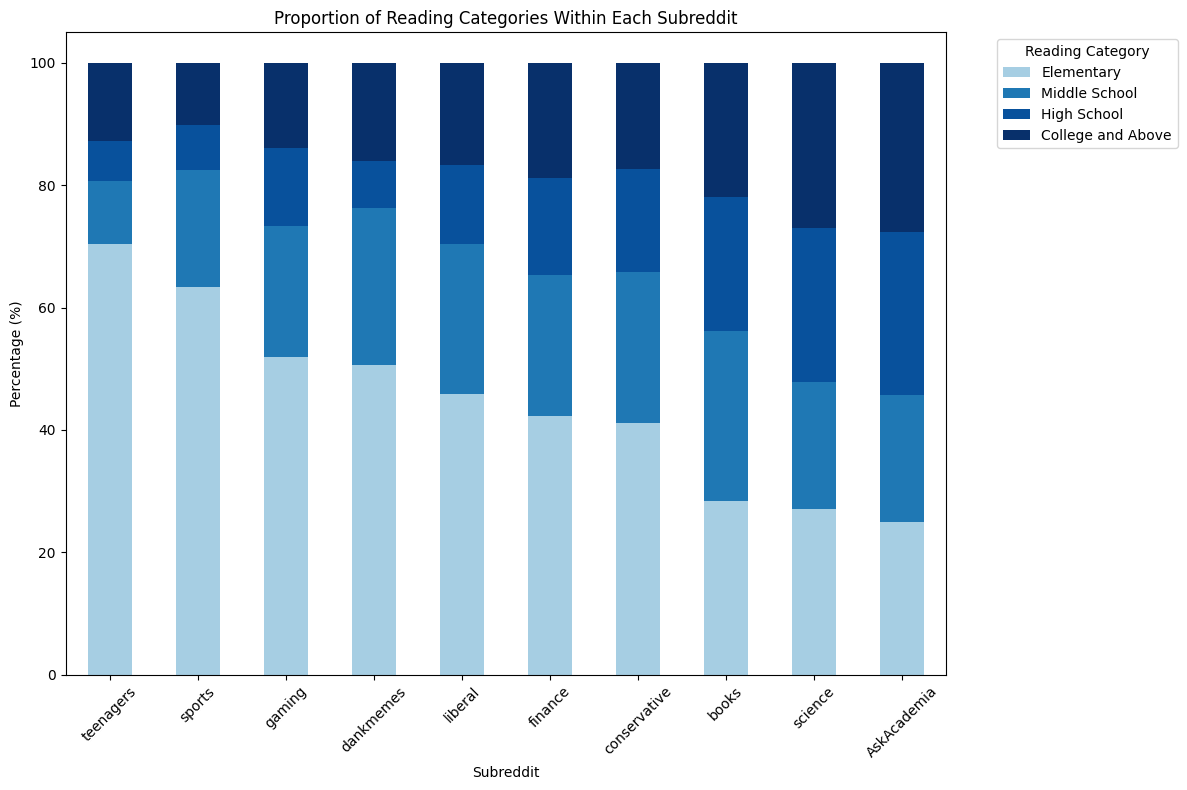

In [46]:
proportions = df.groupby(['subreddit', 'reading_category']).size().reset_index(name='count')

totals = proportions.groupby('subreddit')['count'].transform('sum')
proportions['percentage'] = proportions['count'] / totals * 100

proportions['reading_category'] = pd.Categorical(proportions['reading_category'], categories=reading_order, ordered=True)

colors = {
    'Elementary': '#a6cee3',
    'Middle School': '#1f78b4',
    'High School': '#08519c',
    'College and Above': '#08306b'
}

pivot_df = proportions.pivot(index='subreddit', columns='reading_category', values='percentage')
pivot_df = pivot_df[reading_order]
pivot_df = pivot_df.sort_values(by='Elementary', ascending=False)

pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12,8),
    color=[colors[level] for level in pivot_df.columns]
)

plt.title('Proportion of Reading Categories Within Each Subreddit')
plt.ylabel('Percentage (%)')
plt.xlabel('Subreddit')
plt.xticks(rotation=45)
plt.legend(title='Reading Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


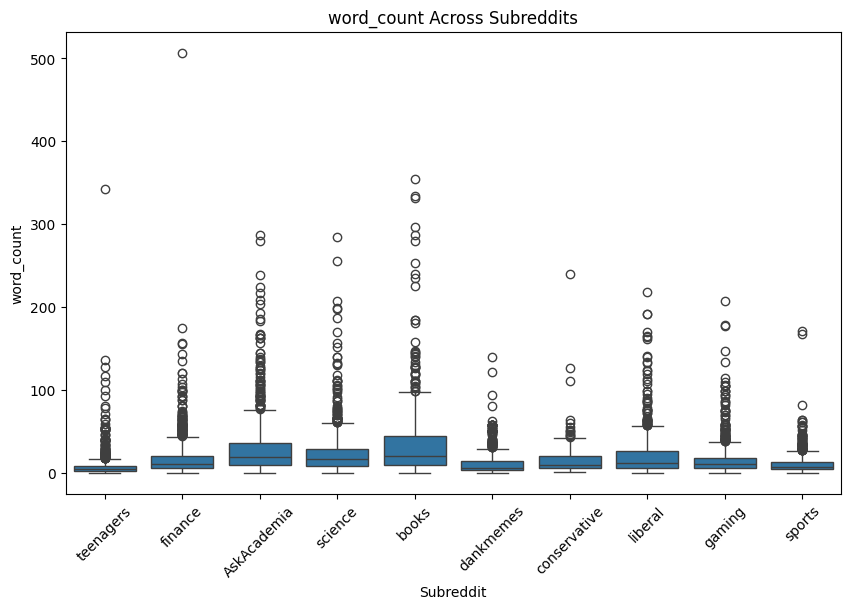

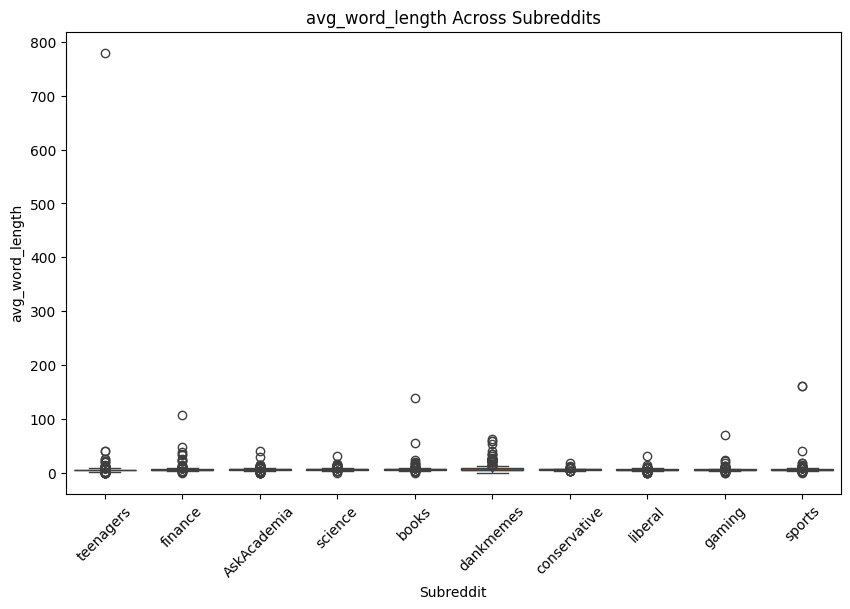

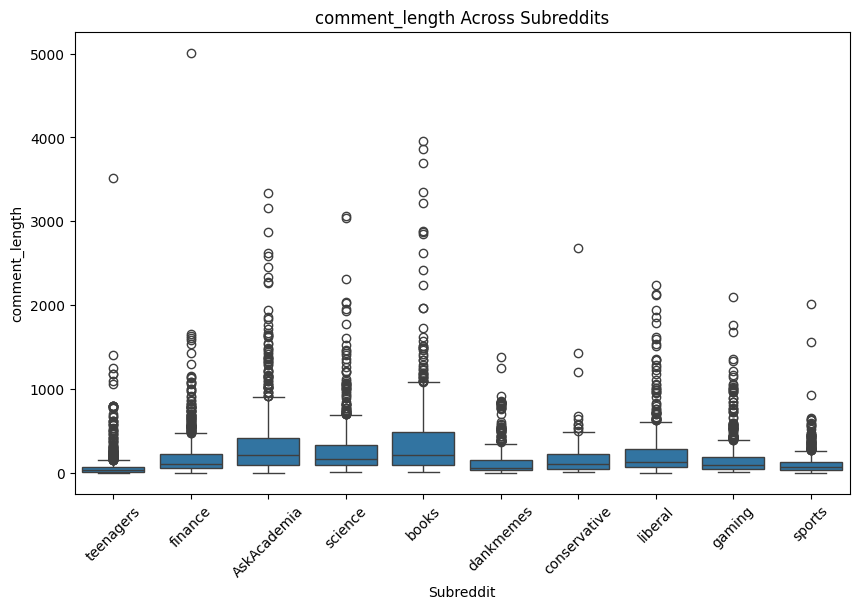

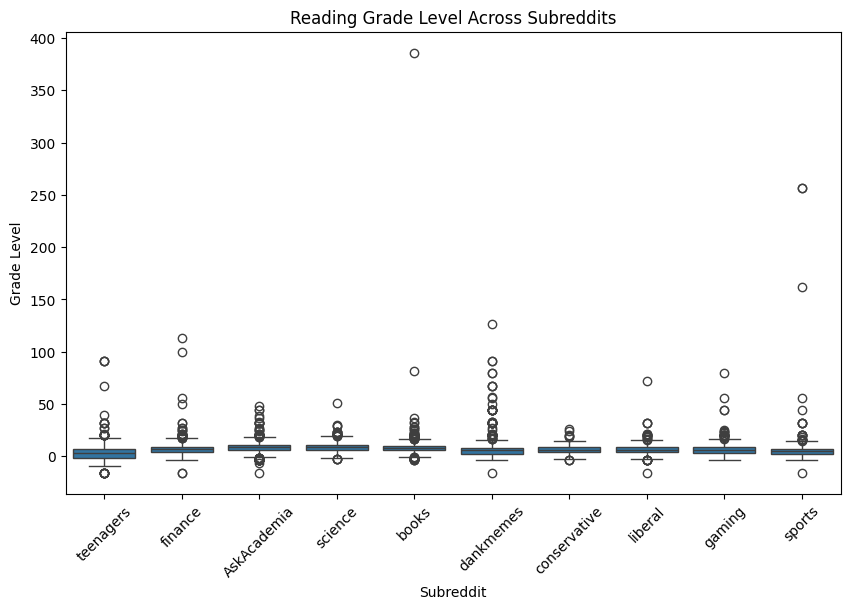

In [47]:
# Boxplots across subreddits
for col in ['word_count', 'avg_word_length', 'comment_length']:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='subreddit', y=col, data=df)
    plt.title(f'{col} Across Subreddits')
    plt.xlabel('Subreddit')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='subreddit', y='reading_grade_level', data=df)
plt.title('Reading Grade Level Across Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Grade Level')
plt.xticks(rotation=45)
plt.show()

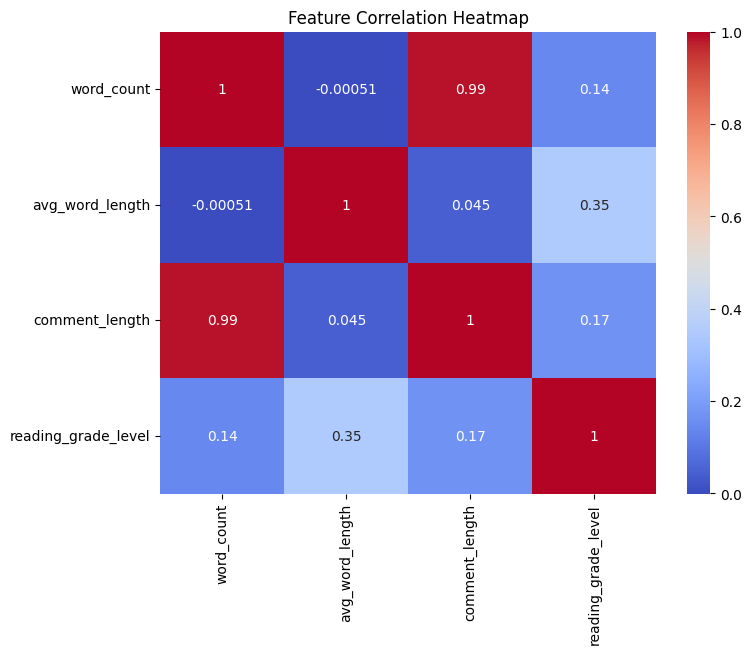

In [48]:
# Correlation heatmap including Reading Grade Level
plt.figure(figsize=(8,6))
sns.heatmap(
    df[['word_count', 'avg_word_length', 'comment_length', 'reading_grade_level']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Feature Correlation Heatmap')
plt.show()


ANOVA result for Word Count: F_onewayResult(statistic=np.float64(103.68975673047517), pvalue=np.float64(9.662974574010748e-85))
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
 AskAcademia        books   3.5962 0.0692  -0.1304   7.3229  False
 AskAcademia conservative  -13.582    0.0 -19.9196  -7.2445   True
 AskAcademia    dankmemes -19.2081    0.0 -22.9978 -15.4184   True
 AskAcademia      finance  -11.292    0.0 -15.0137  -7.5703   True
 AskAcademia       gaming -13.7463    0.0 -17.4468 -10.0459   True
 AskAcademia      liberal  -7.7125    0.0 -11.8939  -3.5311   True
 AskAcademia      science  -4.9537 0.0022  -8.8372  -1.0702   True
 AskAcademia       sports -18.8582    0.0  -22.681 -15.0354   True
 AskAcademia    teenagers -21.3907    0.0 -25.0979 -17.6836   True
       books conservative -17.1783    0.0 -23.5339 -10.8227   True
 

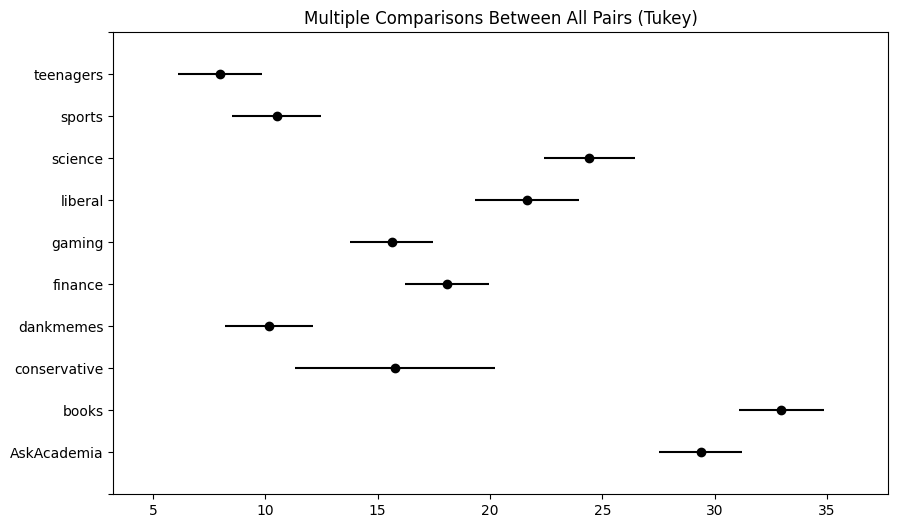

In [49]:
# Statistical Analysis
# ANOVA for word_count across subreddits
anova = stats.f_oneway(
    df[df['subreddit'] == 'teenagers']['word_count'],
    df[df['subreddit'] == 'finance']['word_count'],
    df[df['subreddit'] == 'AskAcademia']['word_count'],
    df[df['subreddit'] == 'science']['word_count'],
    df[df['subreddit'] == 'books']['word_count']
)
print('ANOVA result for Word Count:', anova)

# Tukey HSD post-hoc test
tukey = pairwise_tukeyhsd(df['word_count'], df['subreddit'])
print(tukey)
tukey.plot_simultaneous()
plt.show()


ANOVA result for Reading Grade Level: F_onewayResult(statistic=np.float64(64.62282823376755), pvalue=np.float64(2.8512415830258494e-53))
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
 AskAcademia        books  -0.3271 0.9984 -1.5985  0.9442  False
 AskAcademia conservative  -2.0675 0.0748 -4.2296  0.0945  False
 AskAcademia    dankmemes  -1.7892 0.0005  -3.082 -0.4964   True
 AskAcademia      finance  -1.5975 0.0028 -2.8672 -0.3279   True
 AskAcademia       gaming  -2.6703    0.0 -3.9327 -1.4079   True
 AskAcademia      liberal  -2.2018    0.0 -3.6283 -0.7753   True
 AskAcademia      science  -0.1238    1.0 -1.4487   1.201  False
 AskAcademia       sports  -3.0388    0.0  -4.343 -1.7347   True
 AskAcademia    teenagers  -5.1214    0.0 -6.3861 -3.8568   True
       books conservative  -1.7404 0.2471 -3.9086  0.4278  False
       books    da

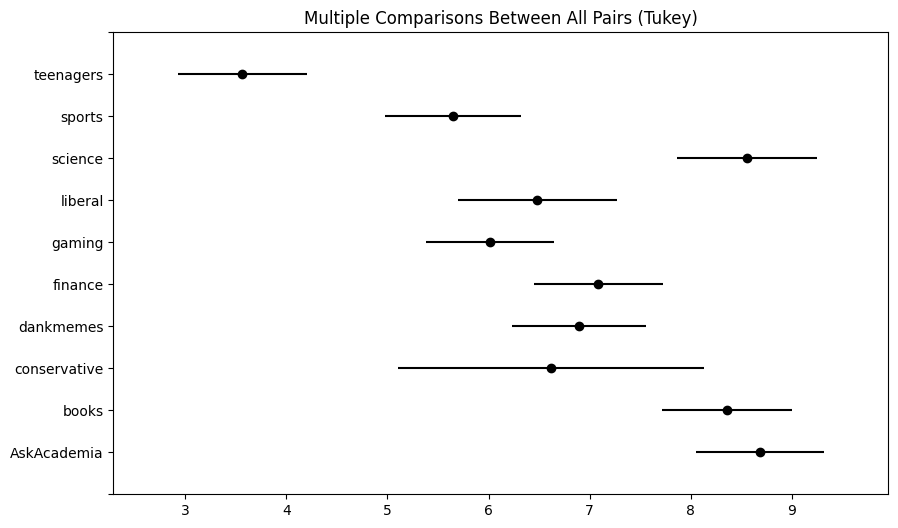

In [50]:
anova_grade = stats.f_oneway(
    df[df['subreddit'] == 'teenagers']['reading_grade_level'],
    df[df['subreddit'] == 'finance']['reading_grade_level'],
    df[df['subreddit'] == 'AskAcademia']['reading_grade_level'],
    df[df['subreddit'] == 'science']['reading_grade_level'],
    df[df['subreddit'] == 'books']['reading_grade_level']
)
print('ANOVA result for Reading Grade Level:', anova_grade)

tukey_grade = pairwise_tukeyhsd(df['reading_grade_level'], df['subreddit'])
print(tukey_grade)
tukey_grade.plot_simultaneous()
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits


<ipython-input-51-d5c390d7b77c>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='plasma')


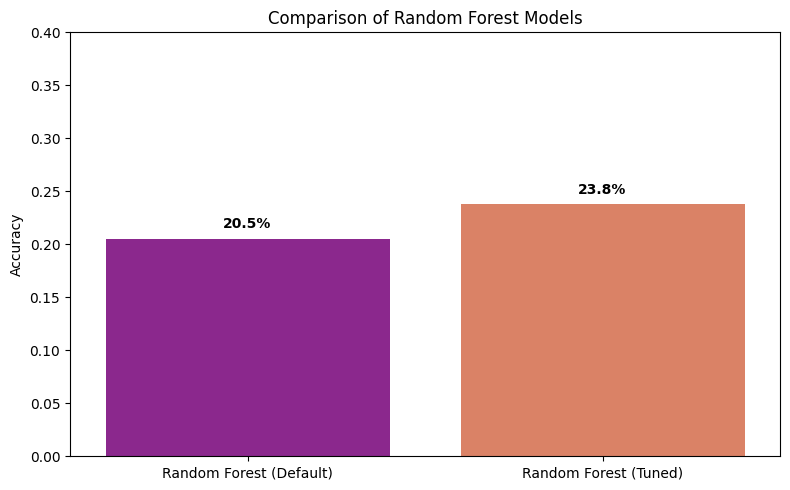

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Encode subreddit labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['subreddit'])
X = df[['word_count', 'avg_word_length', 'comment_length', 'reading_grade_level']]
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Train Tuned Random Forest (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Accuracies
from sklearn.metrics import accuracy_score

acc_rf = accuracy_score(y_test, y_pred)
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)

# Plot comparison
model_names = ['Random Forest (Default)', 'Random Forest (Tuned)']
accuracies = [acc_rf, acc_best_rf]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies, palette='plasma')
plt.title('Comparison of Random Forest Models')
plt.ylabel('Accuracy')
plt.ylim(0, 0.4)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [52]:
def recommend_subreddit(user_comment):
    # Preprocess user comment
    tokens = preprocess_text(user_comment)
    num_words = len(tokens)
    avg_word_length = np.mean([len(word) for word in tokens]) if tokens else 0
    comment_length = len(user_comment)
    grade_level = textstat.flesch_kincaid_grade(user_comment)

    # Build feature array
    input_features = np.array([[num_words, avg_word_length, comment_length, grade_level]])

    # Predict using the best Random Forest model
    prediction_encoded = best_rf.predict(input_features)

    # Decode label back to subreddit name
    predicted_subreddit = label_encoder.inverse_transform(prediction_encoded)

    return predicted_subreddit[0]

# Example usage
user_input = "I'm passionate about programming, technology, and scientific innovations."
print("Recommended subreddit:", recommend_subreddit(user_input))


Recommended subreddit: science


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
